<a href="https://colab.research.google.com/github/Fordreign/my_works/blob/main/TASK_394_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт и преобработка

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Azbuka/Свалка/TASK_394_CLEAR.csv')

In [ ]:
df.sample(4)

,ORDER_NO,SBL_CLIENT_CODE,BASKET,INFULL_BASKET,STORE_CODE,SERVICE_DELIVERY_AV,TIMESLOT_BEG_DATE,TIMESLOT_BEG_TIME,TIMESLOT_END_DATE,TIMESLOT_END_TIME,FACT_DELIVERY_DATE,FACT_DELIVERY_TIME,CANCELED_QTY,REPLACEMENT_QTY,PRICE,ONTIME,COHORT,INFULL
153828,221025-1364314,НЕ ОПРЕДЕЛЕН,6,1.0,44,YANDEX_FOOD,2022-10-25,14:09:00,2022-10-25,04:01:00,2022-10-25,13:58:48,0.0,0.0,1914.59,0,2022-10,1
545045,230102-0013158,НЕ ОПРЕДЕЛЕН,4,1.0,73,YANDEX_FOOD_DC,2023-01-02,20:59:00,2023-01-02,04:01:00,2023-01-02,20:55:07,0.0,0.0,821.07,0,2023-01,1
222581,220127-034009,НЕ ОПРЕДЕЛЕН,11,1.0,24,YANDEX_FOOD,2022-01-27,12:00:00,2022-01-27,04:01:00,2022-01-27,11:50:25,0.0,0.0,4315.92,0,2022-01,1
415018,220202-230566,НЕ ОПРЕДЕЛЕН,4,1.0,35,YANDEX_FOOD,2022-02-02,11:00:00,2022-02-02,04:01:00,2022-02-02,11:10:54,0.0,0.0,719.00,0,2022-02,1


In [ ]:
df_freq = df[df['SBL_CLIENT_CODE'] != 'НЕ ОПРЕДЕЛЕН']

* 3,5,8,9 вопрос

In [ ]:
ontime = pd.DataFrame({
    'COHORT': df[df['SERVICE_DELIVERY_AV'] == 'OMNI']['COHORT'].unique(),
    'Ontime': np.round(df[df['SERVICE_DELIVERY_AV'] == 'OMNI'].groupby('COHORT')['ONTIME'].mean()* 100).astype('int'),
    'Frequency': np.round(df_freq[df_freq['SERVICE_DELIVERY_AV'] == 'OMNI'].groupby('COHORT')['ORDER_NO'].count() / df_freq[df_freq['SERVICE_DELIVERY_AV'] == 'OMNI'].groupby('COHORT')['SBL_CLIENT_CODE'].nunique(), 2),
    'AOV': np.round(df[df['SERVICE_DELIVERY_AV'] == 'OMNI'].groupby('COHORT')['PRICE'].sum() / df[df['SERVICE_DELIVERY_AV'] == 'OMNI'].groupby('COHORT')['SBL_CLIENT_CODE'].count(), 2)
}).reset_index(drop=True).sort_values(by='COHORT')

bins = [0, 80, 85, 90, 95, 100]
labels = ['<80', '80-85', '85-90', '90-95', '95-100']
ontime['Ontime_Cohort'] = pd.cut(ontime['Ontime'], bins=bins, labels=labels)

In [ ]:
correlations_df = pd.DataFrame(columns=['Ontime_Cohort', 'AOV_Correlation', 'Frequency_Correlation'])

for cohort in labels:
    cohort_data = ontime[ontime['Ontime_Cohort'] == cohort]
    correlation_ontime = cohort_data['Ontime'].corr(cohort_data['AOV'])
    correlation_frequency = cohort_data['Ontime'].corr(cohort_data['Frequency'])
    correlations_df = correlations_df.append({'Ontime_Cohort': cohort, 'AOV_Correlation': correlation_ontime, 'Frequency_Correlation': correlation_frequency}, ignore_index=True)

correlations_df['Num_Cohorts'] = correlations_df['Ontime_Cohort'].apply(lambda x: ontime[ontime['Ontime_Cohort'] == x]['Ontime_Cohort'].count())

<ipython-input-95-1deb1479a4e7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlations_df = correlations_df.append({'Ontime_Cohort': cohort, 'AOV_Correlation': correlation_ontime, 'Frequency_Correlation': correlation_frequency}, ignore_index=True)
<ipython-input-95-1deb1479a4e7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlations_df = correlations_df.append({'Ontime_Cohort': cohort, 'AOV_Correlation': correlation_ontime, 'Frequency_Correlation': correlation_frequency}, ignore_index=True)
<ipython-input-95-1deb1479a4e7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlations_df = correlations_df.append({'Ontime_Cohort': cohort, 'AOV_Correlation': correlation_ontime, 'Frequency_Correlation': correlation

* 4, 6 вопрос

In [ ]:
infull = pd.DataFrame({
    'COHORT': df['COHORT'].unique(),
    'Infull' : df.groupby('COHORT')['INFULL'].mean()*100,
    'Infull_Basket' : df.groupby('COHORT')['INFULL_BASKET'].mean(),
    'Frequency': df_freq.groupby('COHORT')['ORDER_NO'].count() / df_freq.groupby('COHORT')['SBL_CLIENT_CODE'].nunique(),
    'AOV': df.groupby('COHORT')['PRICE'].sum() / df.groupby('COHORT')['SBL_CLIENT_CODE'].count(),
    }).reset_index(drop=True).sort_values(by='COHORT').round(2)

labels_infull = ['<72', '73-77', '78+']
bins = [0, 72, 77, float('inf')]

infull['Infull_Cohort'] = pd.cut(infull['Infull'], bins=bins, labels=labels_infull)

# 3.Какая корреляция между OnTime и частотой заказа? + когорты
# 5.Какая корреляция между OnTime и средним чеком? + когорты

Всего у нас около 765т.(415т. без айди) транзакций , сделанных в пилотных магазинах(24,73,35,42,44,160) и доставленных с помощью сервисов ОМНИ, YandexFood, Delivery club за период с 1 января 2018 по 31 июля 2023 годов.


Так как тайм слоты для YandexFood и Delivery club некорректны, то ответим на вопрос в разрезе  сервиса ОМНИ

In [ ]:
df_freq[df_freq['SERVICE_DELIVERY_AV']=='OMNI'].shape

(108004, 18)

In [ ]:
ontime.sample(4)

,COHORT,Ontime,Frequency,AOV,Ontime_Cohort
32,2023-03,83,2.29,3895.69,80-85
12,2021-07,97,1.86,3861.30,95-100
16,2021-11,81,1.97,3821.89,80-85
4,2020-11,83,1.76,3707.85,80-85


<ipython-input-101-94f7dcdbe921>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ontime[ontime['Ontime_Cohort']!='<80'].corr(), annot=True, cmap='coolwarm')


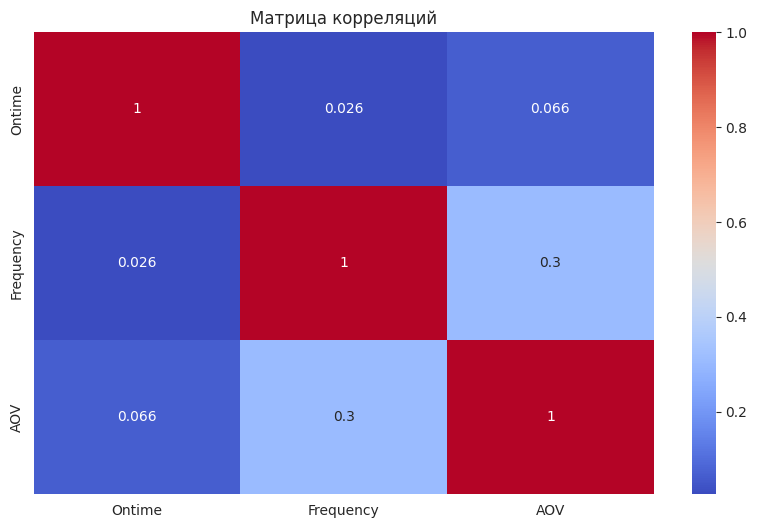

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(ontime[ontime['Ontime_Cohort']!='<80'].corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show();

По когортная корреляция

In [ ]:
correlations_df.reset_index(drop=True, inplace=True)
correlations_df

,Ontime_Cohort,AOV_Correlation,Frequency_Correlation,Num_Cohorts
0,<80,-1.000000,1.000000,2
1,80-85,-0.613884,0.014151,6
2,85-90,-0.643501,-0.440619,9
3,90-95,-0.361631,-0.334300,11
4,95-100,0.227749,-0.565793,10


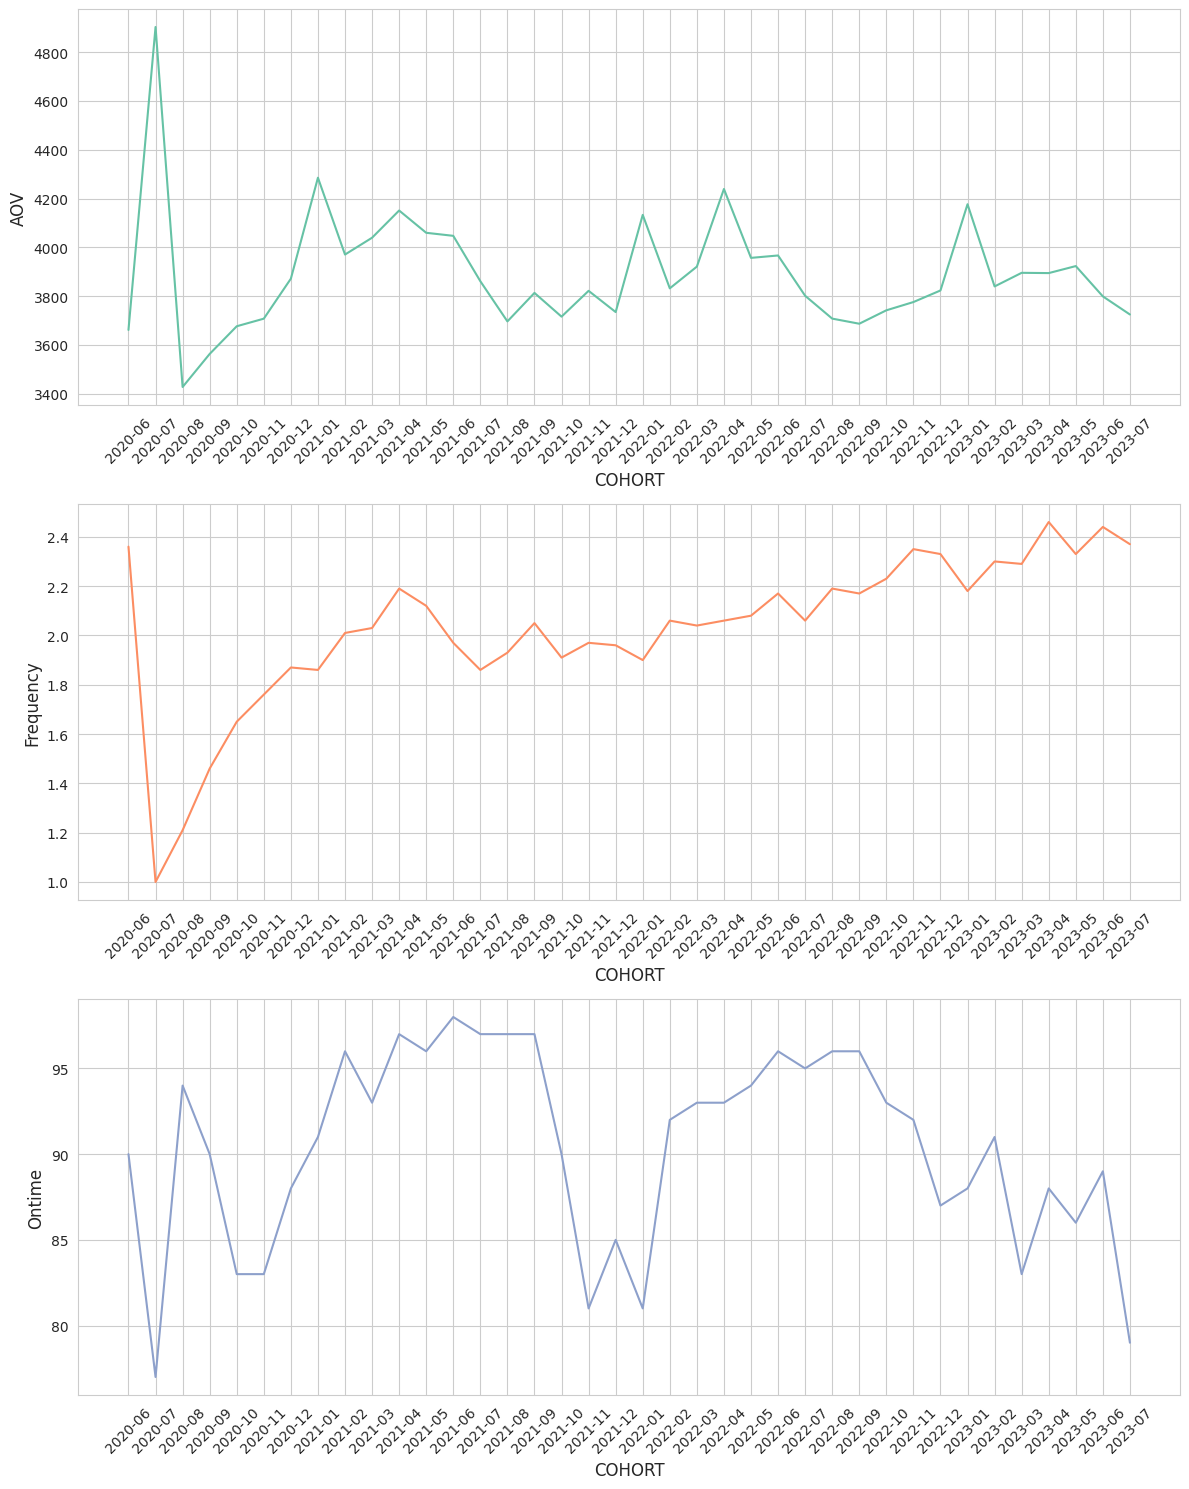

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 15))
metrics = ['AOV', 'Frequency', 'Ontime']
colors = sns.color_palette("Set2", n_colors=3)


fig.subplots_adjust(hspace=0.5)

for i, metric in enumerate(metrics):
    data = ontime.groupby('COHORT')[metric].mean().reset_index()
    sns.lineplot(data=data, x='COHORT', y=metric, ax=axes[i], color=colors[i])
    axes[i].set_xlabel('COHORT', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='both', labelsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
ontime.groupby('Ontime_Cohort')[['Ontime', 'Frequency', 'AOV']].mean().round(2)

,Ontime,Frequency,AOV
Ontime_Cohort,,,
<80,78.00,1.68,4313.80
80-85,82.67,1.92,3828.36
85-90,88.44,2.15,3825.56
90-95,92.82,2.03,3896.49
95-100,96.60,2.07,3896.15


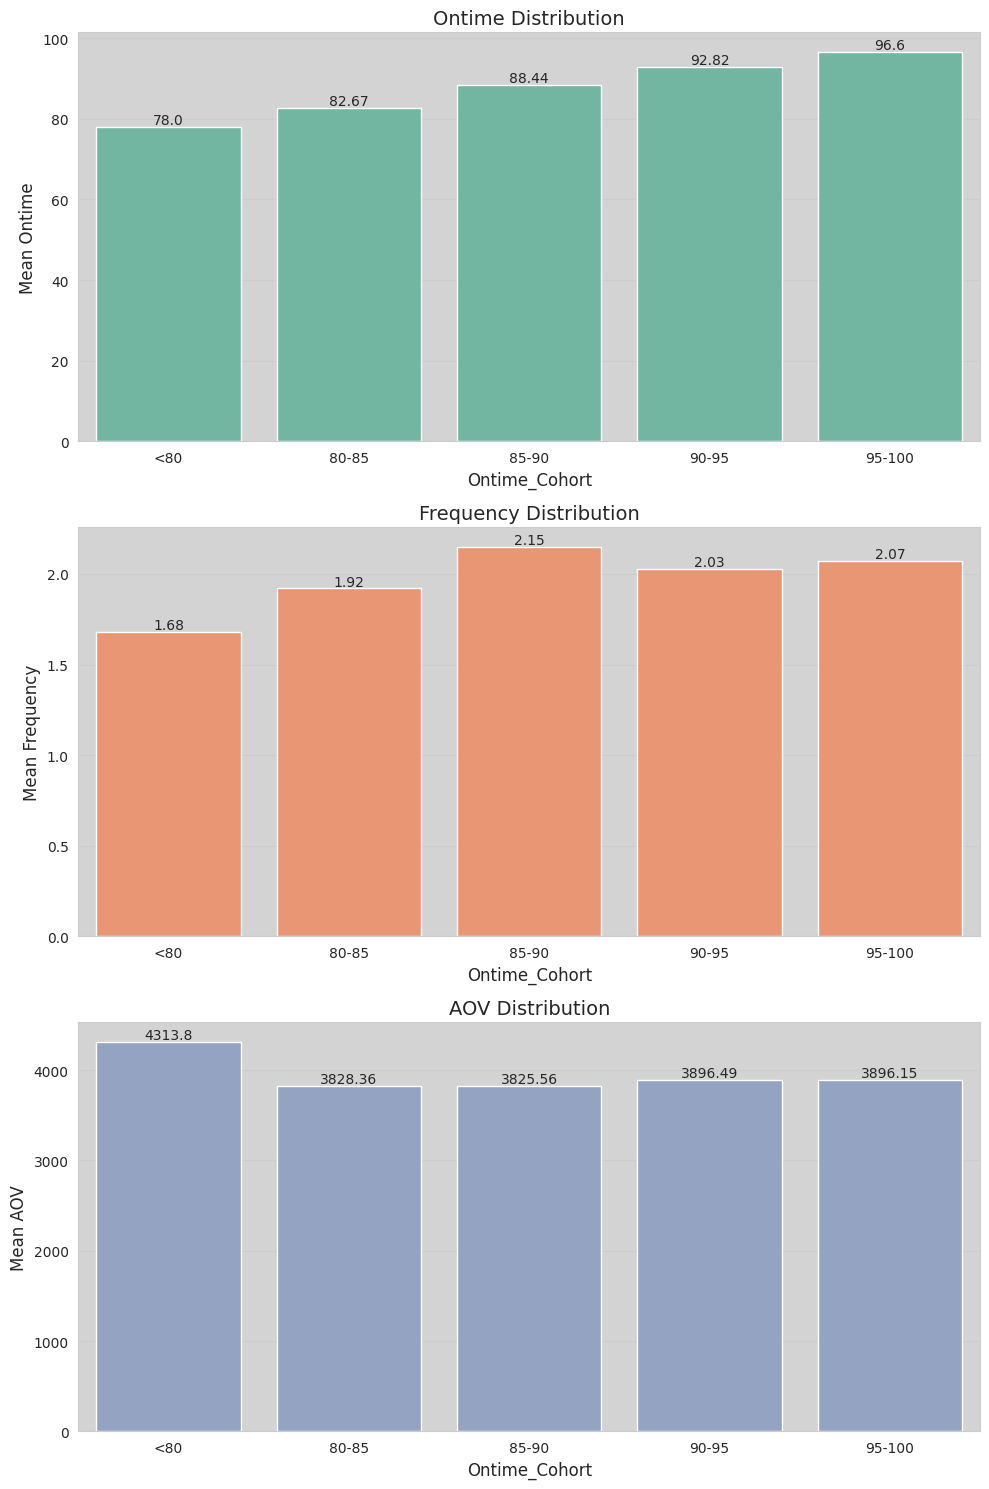

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
metrics = ['Ontime', 'Frequency', 'AOV']
colors = sns.color_palette("Set2", n_colors=3)

fig.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('lightgray')

for i, metric in enumerate(metrics):
    data = ontime.groupby('Ontime_Cohort')[metric].mean().round(2).reset_index()
    sns.barplot(x='Ontime_Cohort', y=metric, data=data, ax=axes[i], palette=[colors[i]])
    axes[i].set_xlabel('Ontime_Cohort', fontsize=12)
    axes[i].set_ylabel('Mean ' + metric, fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].set_title(metric + ' Distribution', fontsize=14)
    for p in axes[i].patches:
        axes[i].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
ontime.groupby('Ontime_Cohort')['Ontime'].count()

Ontime_Cohort
<80        2
80-85      6
85-90      9
90-95     11
95-100    10
Name: Ontime, dtype: int64

In [ ]:
ontime.groupby('Ontime_Cohort')[['Ontime', 'Frequency', 'AOV']].mean().round(2)

,Ontime,Frequency,AOV
Ontime_Cohort,,,
<80,78.00,1.68,4313.80
80-85,82.67,1.92,3828.36
85-90,88.44,2.15,3825.56
90-95,92.82,2.03,3896.49
95-100,96.60,2.07,3896.15


In [ ]:
ontime[ontime['Ontime_Cohort']=='<80']

,COHORT,Ontime,Frequency,AOV,Ontime_Cohort
0,2020-07,77,1.00,4902.66,<80
36,2023-07,79,2.37,3724.94,<80


<ipython-input-109-f96cd336d2af>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(subset.corr(), annot=True, cmap='coolwarm')


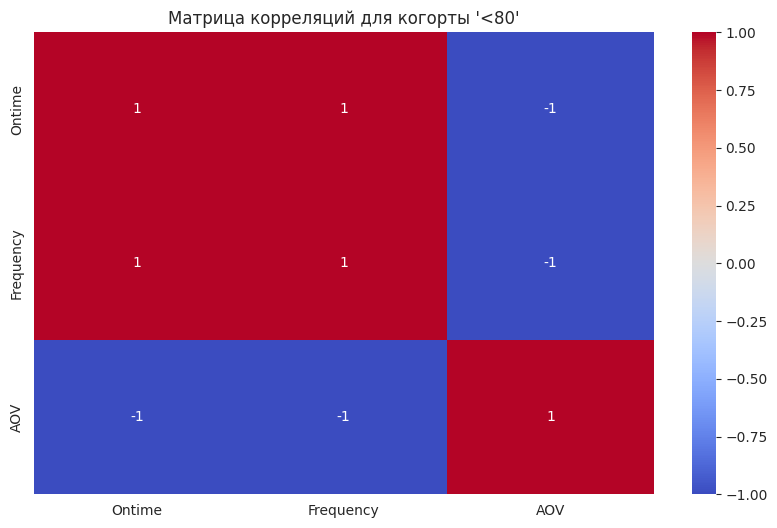

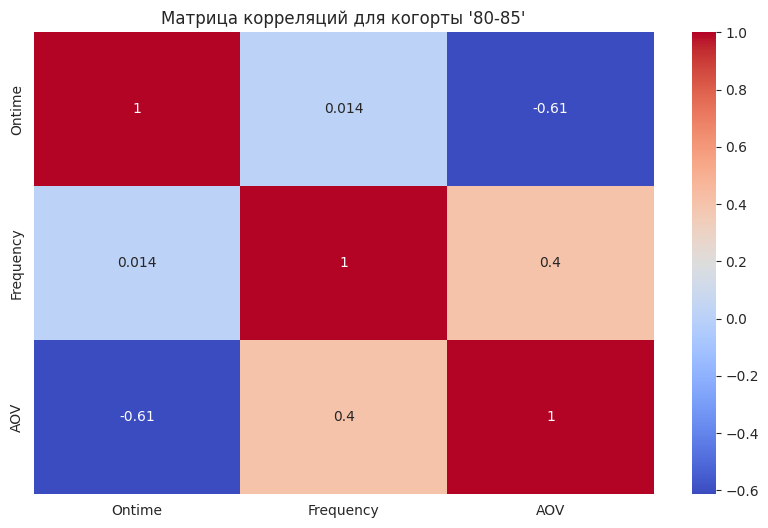

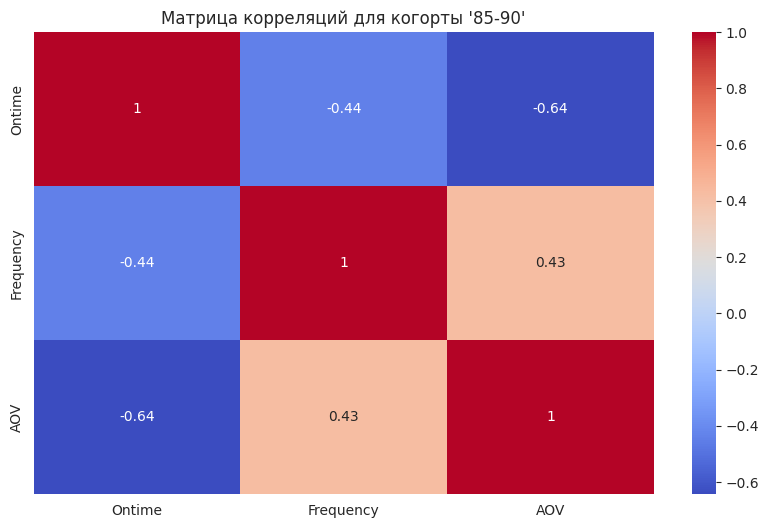

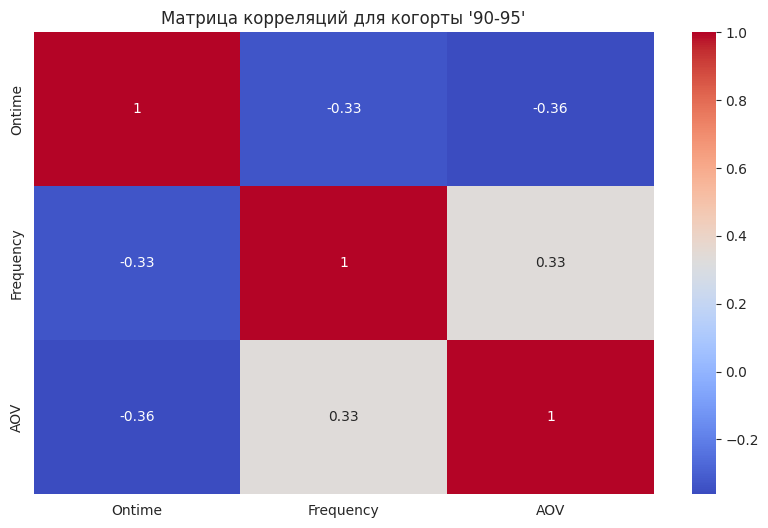

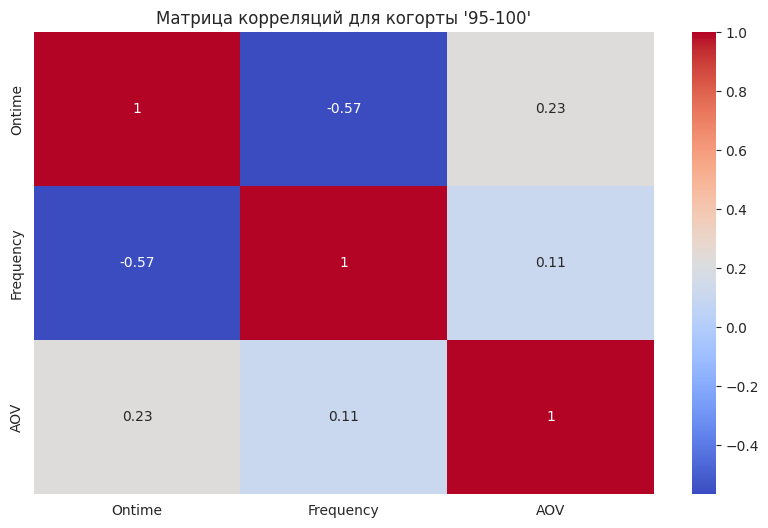

In [ ]:
unique_cohorts = ontime['Ontime_Cohort'].unique().sort_values()

# Цикл по каждой когорте
for cohort in unique_cohorts:
    # Получение подмножества датафрейма для текущей когорты
    subset = ontime[ontime['Ontime_Cohort'] == cohort]

    # Построение тепловой карты матрицы корреляции для текущей когорты
    plt.figure(figsize=(10, 6))
    sns.heatmap(subset.corr(), annot=True, cmap='coolwarm')

    plt.title(f"Матрица корреляций для когорты '{cohort}'")

    plt.show()

In [ ]:
ontime['Ontime_Cohort'].unique().sort_values()

# Цикл по каждой когорте
for cohort in unique_cohorts:
    # Получение подмножества датафрейма для текущей когорты
    subset = ontime[ontime['Ontime_Cohort'] == cohort]

    # Вычисление корреляции между 'AOV' и 'Ontime' для текущей когорты
    correlation_aov = subset['AOV'].corr(subset['Ontime'])

    # Вычисление корреляции между 'Frequency' и 'Ontime' для текущей когорты
    correlation_freq = subset['Frequency'].corr(subset['Ontime'])

    # Вывод корреляций
    print(f"Корреляция между 'AOV' и 'Ontime' для когорты '{cohort}': {correlation_aov}")
    print(f"Корреляция между 'Frequency' и 'Ontime' для когорты '{cohort}': {correlation_freq}")
    print()

Корреляция между 'AOV' и 'Ontime' для когорты '<80': -0.9999999999999999
Корреляция между 'Frequency' и 'Ontime' для когорты '<80': 1.0

Корреляция между 'AOV' и 'Ontime' для когорты '80-85': -0.6138842823672694
Корреляция между 'Frequency' и 'Ontime' для когорты '80-85': 0.014151351443143952

Корреляция между 'AOV' и 'Ontime' для когорты '85-90': -0.6435005206087792
Корреляция между 'Frequency' и 'Ontime' для когорты '85-90': -0.44061901103098455

Корреляция между 'AOV' и 'Ontime' для когорты '90-95': -0.3616312875001343
Корреляция между 'Frequency' и 'Ontime' для когорты '90-95': -0.3343000826024396

Корреляция между 'AOV' и 'Ontime' для когорты '95-100': 0.22774878290234452
Корреляция между 'Frequency' и 'Ontime' для когорты '95-100': -0.5657934334761059



In [ ]:
correlations_df

,Ontime_Cohort,AOV_Correlation,Frequency_Correlation,Num_Cohorts
0,<80,-1.000000,1.000000,2
1,80-85,-0.613884,0.014151,6
2,85-90,-0.643501,-0.440619,9
3,90-95,-0.361631,-0.334300,11
4,95-100,0.227749,-0.565793,10


# 8.На сколько поднимется средний чек, если мы увеличим ontime на 1 п.п.?
# 9.На сколько поднимется частота заказа, если мы увеличим ontime на 1 п.п.?

Регрессионный анали AOV

In [ ]:
X = ontime[['Ontime']]
y = ontime['AOV']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    AOV   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.354
Date:                Thu, 24 Aug 2023   Prob (F-statistic):              0.252
Time:                        12:41:22   Log-Likelihood:                -262.63
No. Observations:                  38   AIC:                             529.3
Df Residuals:                      36   BIC:                             532.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4648.5391    652.470      7.125      0.0

- P-значение коэффициента 'Ontime' равно 0.252, что превышает уровень значимости 0.05. Поэтому переменная 'Ontime' не является статистически значимой для объяснения изменчивости 'AOV'
-В данном случае коэффициент для 'Ontime' равен -8.3825. Это означает, что при увеличении 'Ontime' на 1 п.п., ожидаемое значение AOV снизится на 8.3825. Результат будет отрицательным, поскольку увеличение 'Ontime' связано с уменьшением AOV.


Регрессионный анали Frequency

In [ ]:
X = ontime[ontime['Ontime_Cohort'] != '<80'][['Ontime']]
y = ontime[ontime['Ontime_Cohort'] != '<80']['Frequency']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                   0.02308
Date:                Thu, 24 Aug 2023   Prob (F-statistic):              0.880
Time:                        12:42:14   Log-Likelihood:                -2.2382
No. Observations:                  36   AIC:                             8.476
Df Residuals:                      34   BIC:                             11.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9262      0.818      2.354      0.0

Сводка результатов показывает результаты регрессионной модели. В данном случае, модель OLS R-квадрат составляет 0.001, что означает, что очень небольшая часть изменчивости в переменной Y (Frequency) может быть объяснена переменной X (Ontime). P-значение для коэффициента Ontime равно 0.880, что свидетельствует о том, что этот коэффициент не является статистически значимым.

Таким образом, результаты показывают отсутствие значимой связи между Ontime и Frequency в данной регрессионной модели.


#  4.Какая корреляция между InFull и частотой заказа? + когорты
#  6.Какая корреляция между InFull и частотой заказа? + когорты

Для данного вопроса можно использовать уже те же показатели в разрезе всех сервисов

In [ ]:
df['COHORT'].min()

'2020-06'

In [ ]:
infull.head()

,COHORT,Infull,Infull_Basket,Frequency,AOV,Infull_Cohort
37,2020-06,82.95,0.97,3.00,2001.85,78+
0,2020-07,69.23,0.98,1.00,4902.66,<72
1,2020-08,73.58,0.97,1.21,3427.99,73-77
2,2020-09,68.43,0.96,1.46,3563.40,<72
3,2020-10,63.91,0.96,1.65,3676.78,<72


<ipython-input-116-f93581467749>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(infull.drop(['Frequency'], axis=1).corr(), annot=True, cmap='coolwarm')


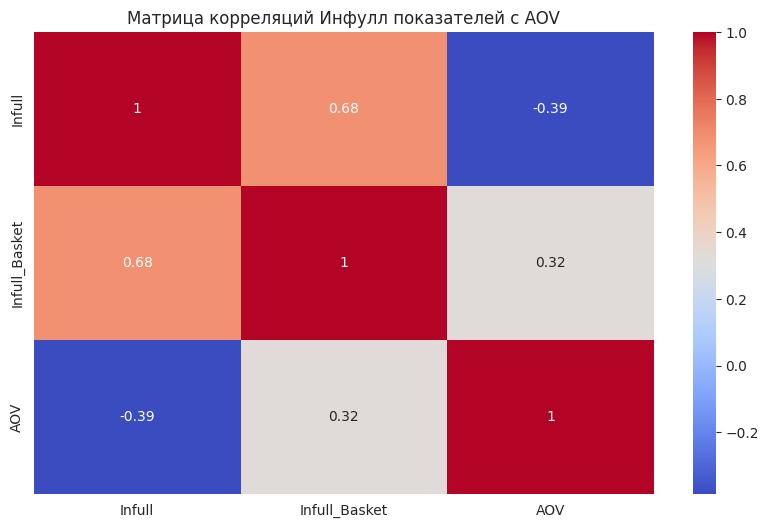

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(infull.drop(['Frequency'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Инфулл показателей с AOV')
plt.show();

<ipython-input-117-2d708caf11d6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(infull.drop(['Infull_Basket','Frequency'] , axis=1).corr(), annot=True, cmap='coolwarm')


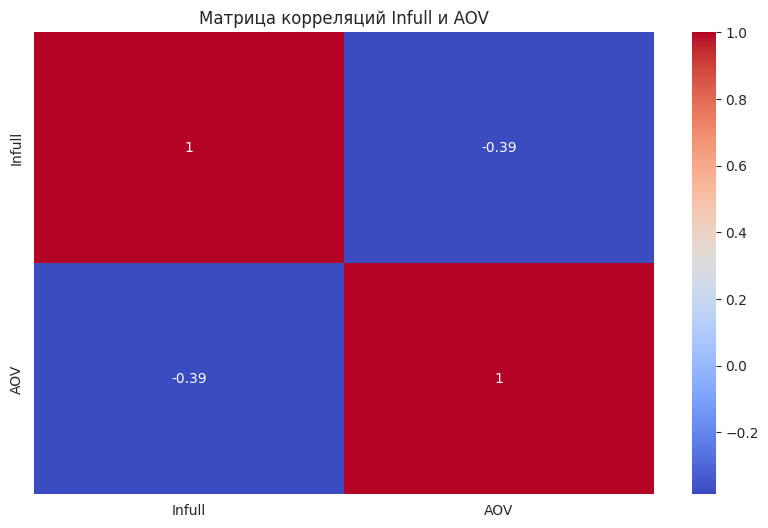

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(infull.drop(['Infull_Basket','Frequency'] , axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Infull и AOV')
plt.show();

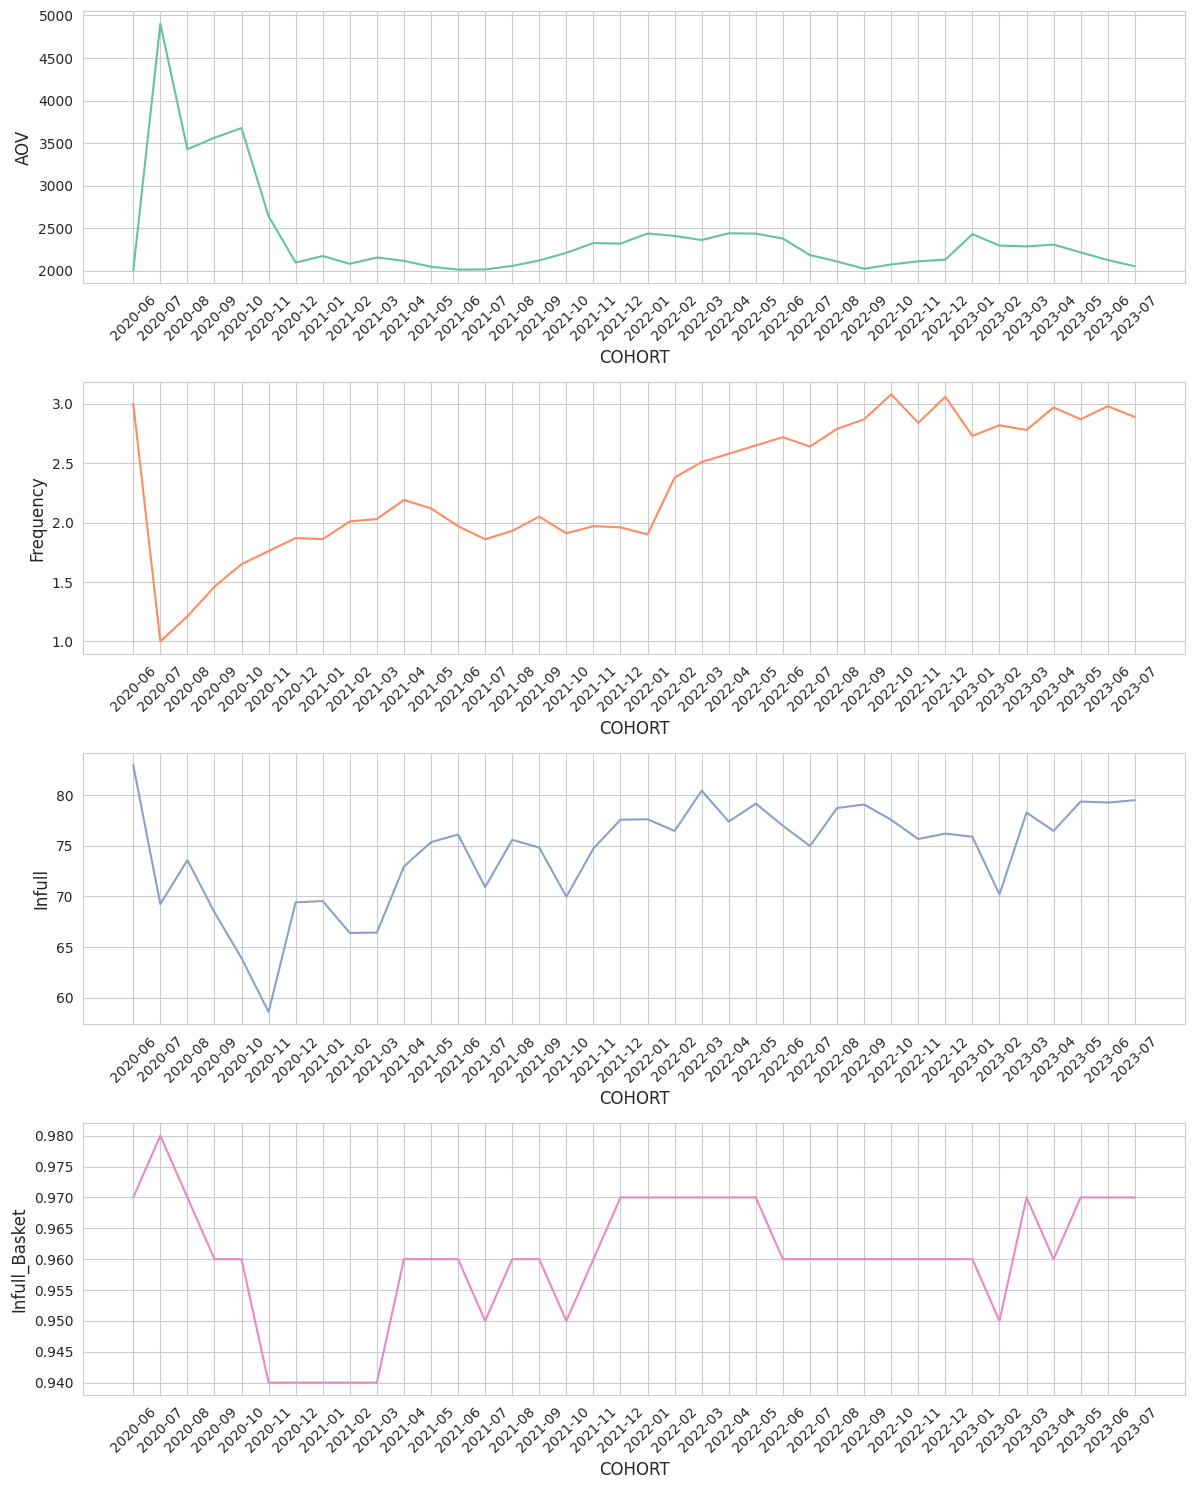

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(12, 15))
metrics = ['AOV', 'Frequency', 'Infull', 'Infull_Basket']
colors = sns.color_palette("Set2", n_colors=4)

# Установка ширины графиков
fig.subplots_adjust(hspace=0.5)

# Построение графика линий для каждой метрики
for i, metric in enumerate(metrics):
    data = infull.groupby('COHORT')[metric].mean().reset_index()
    sns.lineplot(data=data, x='COHORT', y=metric, ax=axes[i], color=colors[i])
    axes[i].set_xlabel('COHORT', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='both', labelsize=10)
    axes[i].tick_params(axis='x', rotation=45)

# Отображение графиков линий
plt.tight_layout()
plt.show()


Частота

In [ ]:
infull[['Infull','Infull_Basket', 'Frequency']].corr()

,Infull,Infull_Basket,Frequency
Infull,1.000000,0.684915,0.645132
Infull_Basket,0.684915,1.000000,0.178924
Frequency,0.645132,0.178924,1.000000


<ipython-input-120-8d2ee39bd4e6>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(infull[infull['COHORT'] >= '2022-02'].drop(['Infull_Basket','AOV'] , axis=1).corr(), annot=True, cmap='coolwarm')


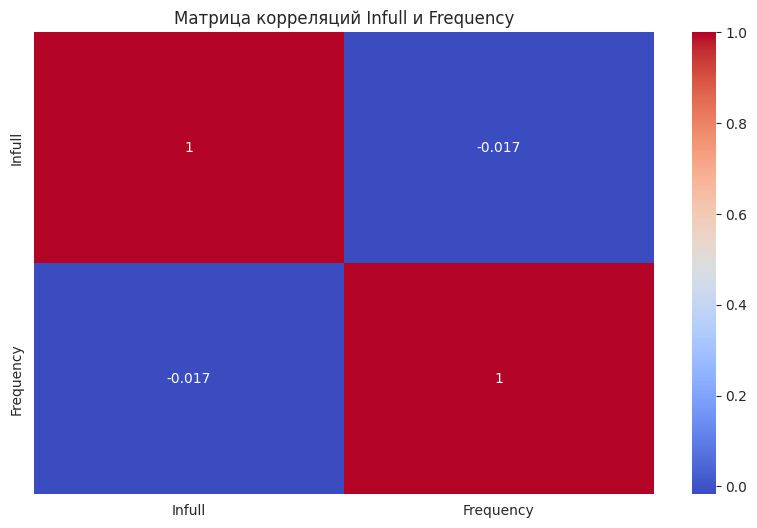

In [ ]:
# Для частоты взяли периоды с 2 февр 22г
plt.figure(figsize=(10, 6))
sns.heatmap(infull[infull['COHORT'] >= '2022-02'].drop(['Infull_Basket','AOV'] , axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Infull и Frequency')
plt.show();

<ipython-input-121-ae03155095cf>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(infull.drop(['Infull','AOV'] , axis=1).corr(), annot=True, cmap='coolwarm')


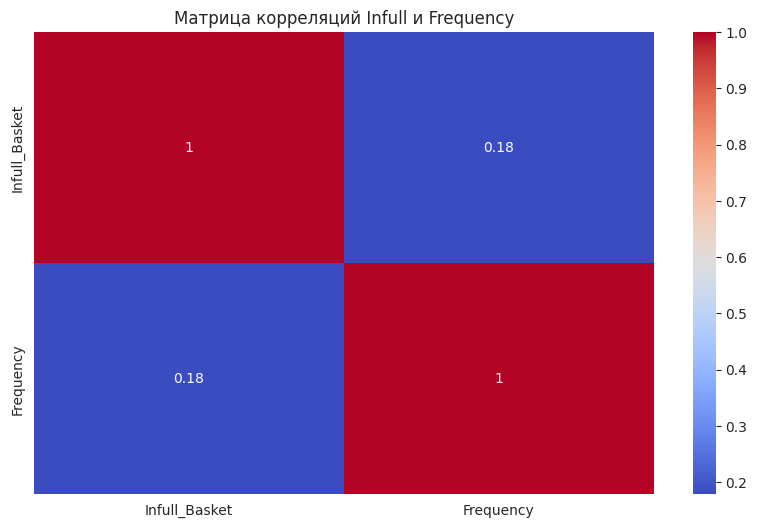

In [ ]:
# Для частоты взяли периоды с 2 февр 22г
plt.figure(figsize=(10, 6))
sns.heatmap(infull.drop(['Infull','AOV'] , axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Infull и Frequency')
plt.show();

По кагортам Infull

In [ ]:
infull[infull['COHORT'] >= '2022-02'].groupby('Infull_Cohort')['Infull'].count()

Infull_Cohort
<72       1
73-77     7
78+      10
Name: Infull, dtype: int64

In [ ]:
infull.groupby('Infull_Cohort')['Infull'].count()

Infull_Cohort
<72      11
73-77    14
78+      13
Name: Infull, dtype: int64

In [ ]:
# INFULL по кагортам и ср показатели
infull.groupby('Infull_Cohort')[['Infull', 'Frequency', 'AOV']].mean().round(2)

,Infull,Frequency,AOV
Infull_Cohort,,,
<72,67.55,1.84,2710.77
73-77,75.40,2.34,2290.58
78+,78.98,2.68,2222.45


In [ ]:
# частота по когортам с февраля 22
infull[infull['COHORT'] >= '2022-02'].groupby('Infull_Cohort')[['Infull','Frequency','AOV']].mean().round(2)

,Infull,Frequency,AOV
Infull_Cohort,,,
<72,70.19,2.82,2296.13
73-77,76.08,2.76,2279.38
78+,78.86,2.80,2213.11


# 11.На сколько поднимется средний чек, если мы увеличим infull на 1 п.п.?
# 12.На сколько поднимется частота заказа, если мы увеличим infull на 1 п.п.?

In [ ]:
infull.head()

,COHORT,Infull,Infull_Basket,Frequency,AOV,Infull_Cohort
37,2020-06,82.95,0.97,4.95,2001.85,78+
0,2020-07,69.23,0.98,1.30,4902.66,<72
1,2020-08,73.58,0.97,1.58,3427.99,73-77
2,2020-09,68.43,0.96,1.90,3563.40,<72
3,2020-10,63.91,0.96,2.21,3676.78,<72


In [ ]:
X = infull[infull['COHORT']>'2022-02']['Infull']
y = infull[infull['COHORT']>'2022-02']['Frequency']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                   0.09307
Date:                Thu, 24 Aug 2023   Prob (F-statistic):              0.765
Time:                        13:04:01   Log-Likelihood:                 7.4335
No. Observations:                  17   AIC:                            -10.87
Df Residuals:                      15   BIC:                            -9.201
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2138      1.322      2.430      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


-"Frequency" (Частота заказов) уменьшится на 0.0949, если "Infull" увеличится
на 1 п.п.

 -Здесь p-значение для параметра "Infull" равно 0.532, что больше стандартного уровня значимости 0.05.
 Поэтому результаты не имеют статистически значимой для объяснения изменчивости "Frequency"

In [ ]:
X = infull['Infull']
y = infull['AOV']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    AOV   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     6.297
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0167
Time:                        13:12:20   Log-Likelihood:                -292.01
No. Observations:                  38   AIC:                             588.0
Df Residuals:                      36   BIC:                             591.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5613.9839   1288.158      4.358      0.0

-Если мы увеличим "Infull" на 1 п.п., то ожидается, что "AOV" (средний чек) изменится на  -43.3767.
-При это p-значение для параметра "Infull" равно стандартному уровню значимости 0.05. Это означает, что нет достаточных
